In [15]:
import numpy as np
import os
import itertools
import time
import torch
import math
from inspect import isfunction
from functools import partial

import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
# import tensorflow as tf

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import splev, splprep, interp1d
from scipy.integrate import cumtrapz

from scipy.signal import savgol_filter

def setdownflap(airfoil, theta=2, pose=0.65):
    lh_idx = np.argmin(airfoil[:,0])
    lh_x = airfoil[lh_idx, 0]
    # Get trailing head
    th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
    # Interpolate
    f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
    f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
    xx = np.linspace(lh_x, th_x, num=1000)
    yy_up = f_up(xx)
    yy_low = f_low(xx)
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down = np.zeros([1000, 2])
    af_down[:,0] = xx
    af_down[:,1] = yy_low
    _i = int(pose * 1000)
    flap = af_down[_i:,:]
    flap = smooth_line(flap, flap.shape[0],3)
    flap_new = flap - flap[0,:]
    flap_new = np.matmul(flap_new, R) + flap[0,:]
    af_down_new = np.copy(af_down)
    af_down_new[_i:,:] = np.copy(flap_new)
    xhat, yhat = savgol_filter((af_down_new[_i-200:_i,0], af_down_new[_i-200:_i,1]), 50, 3)
    af_down_new[_i-200:_i,0] = xhat
    af_down_new[_i-200:_i,1] = yhat
    xhat, yhat = savgol_filter((af_down_new[_i:,0], af_down_new[_i:,1]), 50, 3)
    af_down_new[_i:,0] = xhat
    af_down_new[_i:,1] = yhat
    theta = np.arctan2(af_down_new[-1,1] - af_down[-1,1], 1)
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down_new = np.matmul(af_down_new, R)
    af_up = np.zeros([1000, 2])
    af_up[:,0] = np.flip(xx)
    af_up[:,1] = np.flip(yy_up)
    af = np.zeros([1999,2])
    af[:1000,:] = af_up
    af[1000:,:] = af_down_new[1:,:]
    af = interpolate(af, 256, 3)
    return af

def setupflap(airfoil, theta=-2, pose=0.65):
    lh_idx = np.argmin(airfoil[:,0])
    lh_x = airfoil[lh_idx, 0]
    # Get trailing head
    th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
    # Interpolate
    f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
    f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
    xx = np.linspace(lh_x, th_x, num=1000)
    yy_up = f_up(xx)
    yy_low = f_low(xx)
    theta = theta * np.pi / 180
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down = np.zeros([1000, 2])
    af_down[:,0] = xx
    af_down[:,1] = yy_up
    _i = int(pose * 1000)
    flap = af_down[_i:,:]
    flap = smooth_line(flap, flap.shape[0],3)
    flap_new = flap - flap[0,:]
    flap_new = np.matmul(flap_new, R) + flap[0,:]
    af_down_new = np.copy(af_down)
    af_down_new[_i:,:] = np.copy(flap_new)
    xhat, yhat = savgol_filter((af_down_new[_i-200:_i,0], af_down_new[_i-200:_i,1]), 50, 3)
    af_down_new[_i-200:_i,0] = xhat
    af_down_new[_i-200:_i,1] = yhat
    xhat, yhat = savgol_filter((af_down_new[_i:,0], af_down_new[_i:,1]), 50, 3)
    af_down_new[_i:,0] = xhat
    af_down_new[_i:,1] = yhat
    theta = np.arctan2(af_down_new[-1,1] - af_down[-1,1], 1)
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    af_down_new = np.matmul(af_down_new, R)
    af_up = np.zeros([1000, 2])
    af_up[:,0] = xx
    af_up[:,1] = yy_low
    af = np.zeros([1999,2])
    af[:1000,:] = np.flip(af_down_new[:,:], axis=0)
    af[1000:,:] = af_up[1:,:]
    af = interpolate(af, 256, 3)
    return af

def smooth_line(Q, N, k, D=20, resolution=1000):
    ''' Interpolate N points whose concentration is based on curvature. '''
    res, fp, ier, msg = splprep(Q.T, u=None, k=k, s=1e-6, per=0, full_output=1)
    tck, u = res
    uu = np.linspace(u.min(), u.max(), resolution)
    x, y = splev(uu, tck, der=0)
    dx, dy = splev(uu, tck, der=1)
    ddx, ddy = splev(uu, tck, der=2)
    cv = np.abs(ddx*dy - dx*ddy)/(dx*dx + dy*dy)**1.5 + D
    cv_int = cumtrapz(cv, uu, initial=0)
    fcv = interp1d(cv_int, uu)
    cv_int_samples = np.linspace(0, cv_int.max(), N)
    u_new = fcv(cv_int_samples)
    x_new, y_new = splev(u_new, tck, der=0)
    xy_new = np.vstack((x_new, y_new)).T
    return xy_new

def show_airfoil(af):
    fig, axs = plt.subplots(1, 1)
    axs.plot(af[:,0], af[:,1])
    axs.set_aspect('equal', 'box')
    fig.tight_layout()
    plt.show()

def derotate(airfoil):
    airfoil = Normalize(airfoil)
    ptail = 0.5 * (airfoil[0,:]+airfoil[-1,:])
    ptails = np.expand_dims(ptail, axis=0)
    ptails = np.repeat(ptails, airfoil.shape[0], axis=0)
    i = airfoil[:,0].argmin()
    phead = airfoil[i,:]
    theta = np.arctan2(-(airfoil[i,1] - ptail[1]), -(airfoil[i,0] - ptail[0]))
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    airfoil_R = airfoil
    airfoil_R -= np.repeat(np.expand_dims(phead, axis=0), airfoil_R.shape[0], axis=0)
    airfoil_R = np.matmul(airfoil_R, R)
    return airfoil_R

def Normalize(airfoil):
    airfoil[:,0] -= airfoil[:,0].min()
    r = np.maximum(airfoil[0,0], airfoil[-1,0])
    r = float(1.0/r)
    return airfoil * r

def interpolate(airfoil, points = 256, N = 3):
    a = 0.1
    b = 2
    af = np.copy(airfoil)
    lh_idx = np.argmin(af[:,0])
    lh_x = af[lh_idx, 0]
    th_x = np.minimum(af[0,0], af[-1,0])
    f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
    f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
    x = np.linspace(0,1,points//2)
    # y = ((np.cos(np.pi + x * np.pi) + 1) / 2) ** 2
    y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
    xx_down = y * (af[-1,0] - lh_x) + lh_x
    x = np.linspace(0,1,points//2+1)
    # y = ((np.cos(np.pi + x * np.pi) + 1) / 2) ** 2
    y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
    xx_up = y * (af[0,0] - lh_x) + lh_x
    yy_low = f_low(xx_down)
    yy_up = f_up(xx_up)
    aff = np.zeros([points,2])
    aff[:points//2,0] = np.flip(xx_up[1:])
    aff[:points//2,1] = np.flip(yy_up[1:])
    aff[points//2:,0] = xx_down
    aff[points//2:,1] = yy_low
    return aff


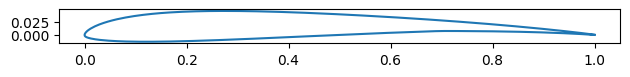

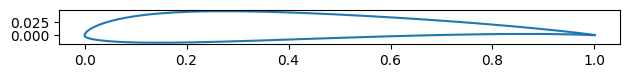

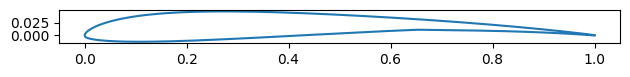

In [63]:
airfoil = np.loadtxt('BETTER/20150114-50 +2 d.dat', skiprows=1)
airfoil = interpolate(airfoil, 256, 3)
show_airfoil(airfoil)
af = np.copy(airfoil)
af = setdownflap(af, -2, 0.7)
show_airfoil(af)
af = setdownflap(af, theta=3, pose=0.65)
af = interpolate(af, 256, 3)
show_airfoil(af)

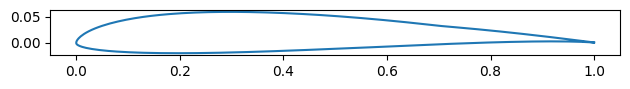

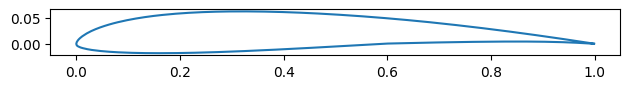

In [17]:
from airfoil_process import *
airfoil = np.loadtxt('/Users/liuhaotian/Desktop/Glider/SynerJ/SynerJ-100.dat', skiprows=1)
airfoil = derotate(airfoil)
airfoil_i = np.copy(airfoil)
airfoil_i = derotate(airfoil_i)
airfoil_i = interpolate(airfoil_i, 256, 3)
show_airfoil(airfoil)
af = setupflap(airfoil_i, theta=2, pose=0.7)
af = setdownflap(af, theta=2, pose=0.6)
af = interpolate(af, 256, 3)
show_airfoil(af)
np.savetxt('tmp/airfoil.dat', af)

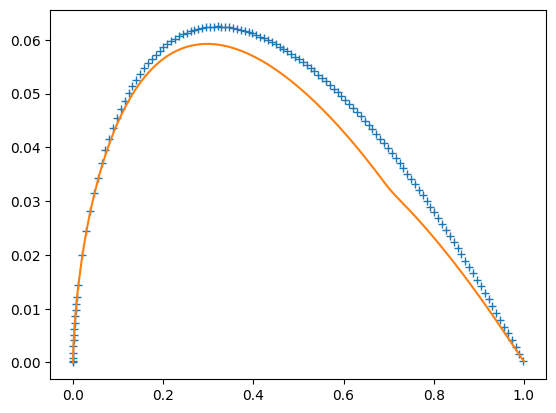

In [18]:
lh_idx = np.argmin(af[:,0])
lh_x = af[lh_idx, 0]
# Get trailing head
th_x = np.minimum(af[0,0], af[-1,0])
# Interpolate
f_up = interp1d(af[:lh_idx+1,0], af[:lh_idx+1,1])
f_low = interp1d(af[lh_idx:,0], af[lh_idx:,1])
points = 256
a = 0.1
b = 2
x = np.linspace(0,1,points//2)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_down = y * (af[-1,0] - lh_x) + lh_x
x = np.linspace(0,1,points//2+1)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_up = y * (af[0,0] - lh_x) + lh_x
yy_up = f_up(xx_up)
yy_low = f_low(xx_down)
plt.plot(xx_up[:],yy_up[:], '+')
# plt.plot(xx_down[:],yy_low[:], '+')

lh_idx = np.argmin(airfoil[:,0])
lh_x = airfoil[lh_idx, 0]
# Get trailing head
th_x = np.minimum(airfoil[0,0], airfoil[-1,0])
# Interpolate
f_up = interp1d(airfoil[:lh_idx+1,0], airfoil[:lh_idx+1,1])
f_low = interp1d(airfoil[lh_idx:,0], airfoil[lh_idx:,1])
points = 256
a = 0.1
b = 2
x = np.linspace(0,1,points//2)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_down = y * (airfoil[-1,0] - lh_x) + lh_x
x = np.linspace(0,1,points//2+1)
y = np.where(x > a, (x-a) * (1-a ** b) / (1 - a) + a ** b, x ** b)
xx_up = y * (airfoil[0,0] - lh_x) + lh_x
yy_up = f_up(xx_up)
yy_low = f_low(xx_down)
plt.plot(xx_up[:],yy_up[:], '')
# plt.plot(xx_down[:],yy_low[:], '')
# plt.plot(airfoil[lh_idx:,0],airfoil[lh_idx:,1], '+')

In [19]:
v = 10
d = 0.3
span = 2.5
area = d * span
density = 1.225
vis = 1.5 * 10 ** (-5)
reynolds = v * density * d / vis
mass = 6
g = 9.806
cl = mass * g / (0.5 * area * density * (v ** 2))
reynolds, cl

(244999.99999999994, 1.2807836734693878)

In [20]:
from utils_win import *
cl, cd = compute_coeff(af, reynolds, 0, cl)
perf = cl / cd
perf

40.737913486005084

In [83]:
def type2_resqrtcl(mass, diameter, area):
    g = 9.806
    viscosity = 1.5e-5
    re_sqrtcl = np.sqrt(2 * mass * g / density / area) * diameter / viscosity
    return re_sqrtcl

def compute_t2_coeff(airfoil, re_sqrtcl=50000, alpha_min=0, alpha_max = 5, alpha_step = 0.5, n_iter=2000, tmp_dir='tmp'):
    create_dir(tmp_dir)
    gc.collect()
    safe_remove('{}/airfoil.log'.format(tmp_dir))
    fname = '{}/airfoil.dat'.format(tmp_dir)
    with open(fname, 'wb') as f:
        np.savetxt(f, airfoil)
    try:
        if platform.system().lower() == 'windows':
            child = wexpect.spawn('xfoil')
        else:
            child = pexpect.spawn('xfoil')
        timeout = 10
        
        child.expect('XFOIL   c> ', timeout)
        child.sendline('load {}/airfoil.dat'.format(tmp_dir))
        child.expect('Enter airfoil name   s> ', timeout)
        child.sendline('af')
        child.expect('XFOIL   c> ', timeout)
        child.sendline('OPER')
        child.expect('.OPERi   c> ', timeout)
        child.sendline('t2')
        child.expect('.OPERi   c> ', timeout)
        child.sendline('VISC {}'.format(re_sqrtcl))
        child.expect('.OPERv   c> ', timeout)
        child.sendline('ITER {}'.format(n_iter))
        child.expect('.OPERv   c> ', timeout)
        child.sendline('PACC')
        child.expect('Enter  polar save filename  OR  <return> for no file   s> ', timeout)
        child.sendline('{}/airfoil.log'.format(tmp_dir))
        child.expect('Enter  polar dump filename  OR  <return> for no file   s> ', timeout)
        child.sendline()
        child.expect('.OPERva   c> ', timeout)
        child.sendline('aseq {} {} {}'.format(alpha_min, alpha_max, alpha_step))
        child.expect('c> ', timeout)
        child.sendline()
        child.expect('XFOIL   c> ', timeout)
        child.sendline('quit')
        
        child.close()
    
        res = np.loadtxt('{}/airfoil.log'.format(tmp_dir), skiprows=12)
        CL = res[:,1]
        CD = res[:,2]
            
    except Exception as ex:
        # print(ex)
        print('XFoil error!')
        CL = np.nan
        CD = np.nan
        
    safe_remove(':00.bl')
    
    return CL, CD

def gliding_perf(af, mass, d, span, alpha_min=0, alpha_max = 5, alpha_step = 0.5):
    area = d * span
    re_sqrtcl = type2_resqrtcl(mass, d, area)
    cl, cd = compute_t2_coeff(af, re_sqrtcl, alpha_min, alpha_max, alpha_step)
    perf = cl/cd
    vz = np.sqrt((cl ** 3) / (cd ** 2))
    try:
        i = perf.argmax()
        perf = perf.max()
        return perf, cl[i], cd[i], vz.max()
    except:
        return perf, cl, cd, vz


In [84]:
mass = 0.32
g = 9.806
d = 0.145
span = 1.5
area = d * span
viscosity = 1.5e-5

re_sqrtcl = type2_resqrtcl(mass, d, area)

perf, cl, cd, vz = gliding_perf(af, mass, d, span)
perf, cl, cd, vz

(39.911504424778755, 0.6314, 0.01582, 32.67884995148011)

In [ ]:
root = 'synergy2_65/'